In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.applications import MobileNetV2
from keras.layers import Dense
from keras.preprocessing import image

from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!unzip -q  archive.zip

### **Data Preprocessing**

In [ ]:
root_dir = '/content'

def create_dataframe(folder_path):
    data = {'Image': [], 'Class': [], 'pathes': []}
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                if image_name.endswith('.jpg') or image_name.endswith('.png'):
                    image_path = os.path.join(class_path, image_name)
                    data['Image'].append(image_name)
                    data['Class'].append(class_name)
                    data['pathes'].append(image_path)
    return pd.DataFrame(data)

train_df = create_dataframe(os.path.join(root_dir, 'Training'))
test_df = create_dataframe(os.path.join(root_dir, 'Testing'))

train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

print("Train Data:")
print(train_df.head())
print("\nTest Data:")
print(test_df.head())

if os.path.exists('train_data.csv') and os.path.exists('test_data.csv'):
    print("\nCSV files created successfully.")
else:
    print("\nError: CSV files not created.")

Train Data:
            Image     Class                                     pathes
0  image(129).jpg  no_tumor  /content/Training/no_tumor/image(129).jpg
1  image(310).jpg  no_tumor  /content/Training/no_tumor/image(310).jpg
2  image(165).jpg  no_tumor  /content/Training/no_tumor/image(165).jpg
3  image(304).jpg  no_tumor  /content/Training/no_tumor/image(304).jpg
4  image(274).jpg  no_tumor  /content/Training/no_tumor/image(274).jpg

Test Data:
           Image     Class                                   pathes
0  image(43).jpg  no_tumor  /content/Testing/no_tumor/image(43).jpg
1  image(88).jpg  no_tumor  /content/Testing/no_tumor/image(88).jpg
2  image(95).jpg  no_tumor  /content/Testing/no_tumor/image(95).jpg
3  image(54).jpg  no_tumor  /content/Testing/no_tumor/image(54).jpg
4  image(63).jpg  no_tumor  /content/Testing/no_tumor/image(63).jpg

CSV files created successfully.


In [ ]:
brain_df = pd.read_csv('train_data.csv',usecols=[0,1,2])
brain_df.head()

,Image,Class,pathes
0,image(129).jpg,no_tumor,/content/Training/no_tumor/image(129).jpg
1,image(310).jpg,no_tumor,/content/Training/no_tumor/image(310).jpg
2,image(165).jpg,no_tumor,/content/Training/no_tumor/image(165).jpg
3,image(304).jpg,no_tumor,/content/Training/no_tumor/image(304).jpg
4,image(274).jpg,no_tumor,/content/Training/no_tumor/image(274).jpg


In [ ]:
brain_df['Class'].value_counts()

Class
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: count, dtype: int64

In [ ]:
train_data_dir = '/content/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
train_df

,filepaths,labels
0,/content/Training/no_tumor/image(129).jpg,no_tumor
1,/content/Training/no_tumor/image(310).jpg,no_tumor
2,/content/Training/no_tumor/image(165).jpg,no_tumor
3,/content/Training/no_tumor/image(304).jpg,no_tumor
4,/content/Training/no_tumor/image(274).jpg,no_tumor
...,...,...
2865,/content/Training/glioma_tumor/gg (821).jpg,glioma_tumor
2866,/content/Training/glioma_tumor/gg (653).jpg,glioma_tumor
2867,/content/Training/glioma_tumor/gg (174).jpg,glioma_tumor
2868,/content/Training/glioma_tumor/gg (27).jpg,glioma_tumor


In [ ]:
train_data_dir = '/content/Testing'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
ts_df

,filepaths,labels
0,/content/Testing/no_tumor/image(24).jpg,no_tumor
1,/content/Testing/no_tumor/image(25).jpg,no_tumor
2,/content/Testing/no_tumor/image(59).jpg,no_tumor
3,/content/Testing/no_tumor/image(6).jpg,no_tumor
4,/content/Testing/no_tumor/image(73).jpg,no_tumor
...,...,...
389,/content/Testing/glioma_tumor/image.jpg,glioma_tumor
390,/content/Testing/glioma_tumor/image(97).jpg,glioma_tumor
391,/content/Testing/glioma_tumor/image(2).jpg,glioma_tumor
392,/content/Testing/glioma_tumor/image(52).jpg,glioma_tumor


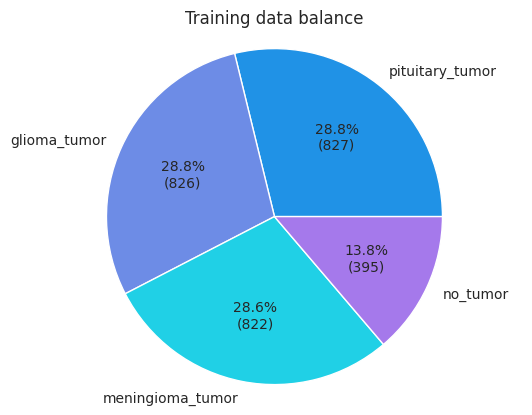

In [ ]:
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

<Axes: xlabel='count', ylabel='Class'>

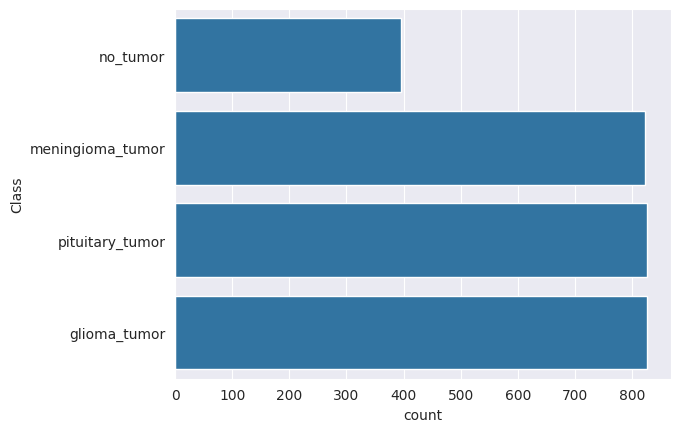

In [ ]:
sns.countplot(brain_df['Class'])

## Mobilenet

In [ ]:
print(brain_df['pathes'])


0         /content/Training/no_tumor/image(129).jpg
1         /content/Training/no_tumor/image(310).jpg
2         /content/Training/no_tumor/image(165).jpg
3         /content/Training/no_tumor/image(304).jpg
4         /content/Training/no_tumor/image(274).jpg
                           ...                     
2865    /content/Training/glioma_tumor/gg (821).jpg
2866    /content/Training/glioma_tumor/gg (653).jpg
2867    /content/Training/glioma_tumor/gg (174).jpg
2868     /content/Training/glioma_tumor/gg (27).jpg
2869    /content/Training/glioma_tumor/gg (296).jpg
Name: pathes, Length: 2870, dtype: object


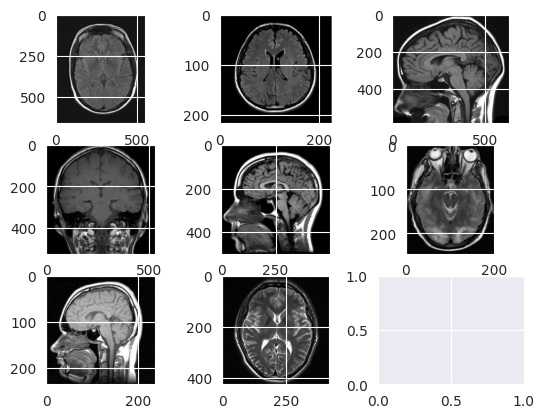

In [ ]:
for x in range (0 ,9):
    img = imread(brain_df['pathes'][x])
    plt.imshow(img)
    plt.subplot(3,3,x+1)

In [ ]:
from PIL.Image import open
brain_df['pixels']=brain_df['pathes'].map(lambda x:np.asarray(open(x).resize((224,224))))

In [ ]:
brain_df.head()

,Image,Class,pathes,pixels
0,image(129).jpg,no_tumor,/content/Training/no_tumor/image(129).jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,image(310).jpg,no_tumor,/content/Training/no_tumor/image(310).jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,image(165).jpg,no_tumor,/content/Training/no_tumor/image(165).jpg,"[[[166, 166, 166], [49, 49, 49], [60, 60, 60],..."
3,image(304).jpg,no_tumor,/content/Training/no_tumor/image(304).jpg,"[[[13, 13, 13], [12, 12, 12], [13, 13, 13], [1..."
4,image(274).jpg,no_tumor,/content/Training/no_tumor/image(274).jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [ ]:
image_list = []
for i in range(0,len(brain_df)):
    brain_img = brain_df['pixels'][i].astype(np.float32)
    img_array = image.img_to_array(brain_img)
    image_list.append(keras.applications.mobilenet_v2.preprocess_input(img_array))

X = np.array(image_list)

print(X.shape)

(2870, 224, 224, 3)


In [ ]:
y = np.array(brain_df.Class)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y
                                                 ,test_size=0.2
                                                ,random_state=0)

print('The shape of the X_train :'+' '+str(X_train.shape))
print('The size of the X_train :'+' '+str(X_train.shape[0]))
print('The shape of the X_test :'+' '+str(X_test.shape))
print('The size of the X_test:'+' '+str(X_test.shape[0]))

The shape of the X_train : (2296, 224, 224, 3)
The size of the X_train : 2296
The shape of the X_test : (574, 224, 224, 3)
The size of the X_test: 574


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_cat = to_categorical(y_train_encoded, num_classes=4)
y_test_cat = to_categorical(y_test_encoded, num_classes=4)

In [ ]:
num_classes = 4
model = Sequential()
model.add(MobileNetV2(input_shape=(224, 224, 3), weights="imagenet", include_top=False))
model.add(keras.layers.GlobalAveragePooling2D())
model.add(Dense(num_classes, activation='softmax'))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.SGD(lr=0.001),
    metrics=['accuracy']
)

model.fit(
    X_train,
    y_train_cat,
    epochs=10,
    verbose=1,
    validation_data=(X_test, y_test_cat)
)

model.save("model_brain_multiclass.h5")
print("Saved multi-class model to disk")

Epoch 1/10
72/72 [==============================] - 458s 6s/step - loss: 0.4728 - accuracy: 0.8267 - val_loss: 0.9669 - val_accuracy: 0.5679
Epoch 2/10
72/72 [==============================] - 417s 6s/step - loss: 0.1347 - accuracy: 0.9573 - val_loss: 0.8491 - val_accuracy: 0.6429
Epoch 3/10
72/72 [==============================] - 403s 6s/step - loss: 0.0572 - accuracy: 0.9900 - val_loss: 1.0637 - val_accuracy: 0.5592
Epoch 4/10
72/72 [==============================] - 401s 6s/step - loss: 0.0348 - accuracy: 0.9926 - val_loss: 1.1669 - val_accuracy: 0.5488
Epoch 5/10
72/72 [==============================] - 395s 5s/step - loss: 0.0166 - accuracy: 0.9991 - val_loss: 1.0662 - val_accuracy: 0.6045
Epoch 6/10
72/72 [==============================] - 381s 5s/step - loss: 0.0189 - accuracy: 0.9983 - val_loss: 1.1039 - val_accuracy: 0.6185
Epoch 7/10
72/72 [==============================] - 398s 6s/step - loss: 0.0116 - accuracy: 0.9996 - val_loss: 1.0629 - val_accuracy: 0.6307
Epoch 8/10
72

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import load_model

pretrained_cnn=load_model('model_brain_multiclass.h5')
label_encoder = LabelEncoder()

y_test_encoded = label_encoder.fit_transform(y_test)

y_test_cat = to_categorical(y_test_encoded, num_classes=4)

eval_score = pretrained_cnn.evaluate(X_test, y_test_cat)

print('Eval loss:', eval_score[0])
print('Eval accuracy:', eval_score[1])



18/18 [==============================] - 31s 2s/step - loss: 0.7220 - accuracy: 0.7509
Eval loss: 0.722028911113739
Eval accuracy: 0.7508710622787476


## XCEPTION

In [ ]:
glioma_tumor = '/content/Training/glioma_tumor'
meningioma_tumor = '/content/Training/meningioma_tumor'
no_tumor = '/content/Training/no_tumor'
pituitary_tumor = '/content/Training/pituitary_tumor'

class_directories = [glioma_tumor,meningioma_tumor, no_tumor, pituitary_tumor]
class_labels = ['glioma_tumor','meningioma_tumor', 'no_tumor', 'pituitary_tumor']

file_paths = []
labels = []

for i, directory in enumerate(class_directories):
    file_list = os.listdir(directory)
    for file_name in file_list:
        file_path = os.path.join(directory, file_name)
        file_paths.append(file_path)
        labels.append(class_labels[i])

file_paths_series = pd.Series(file_paths, name="filepaths")
labels_series = pd.Series(labels, name="labels")
data = pd.concat([file_paths_series, labels_series], axis=1)
df = pd.DataFrame(data)

print(df.head())


                                     filepaths        labels
0   /content/Training/glioma_tumor/gg (81).jpg  glioma_tumor
1  /content/Training/glioma_tumor/gg (637).jpg  glioma_tumor
2  /content/Training/glioma_tumor/gg (766).jpg  glioma_tumor
3   /content/Training/glioma_tumor/gg (98).jpg  glioma_tumor
4  /content/Training/glioma_tumor/gg (285).jpg  glioma_tumor


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(1829, 2)
(718, 2)
(323, 2)


(1829, 2)
(718, 2)
(323, 2)
Found 1829 validated image filenames belonging to 4 classes.
Found 718 validated image filenames belonging to 4 classes.
Found 323 validated image filenames belonging to 4 classes.


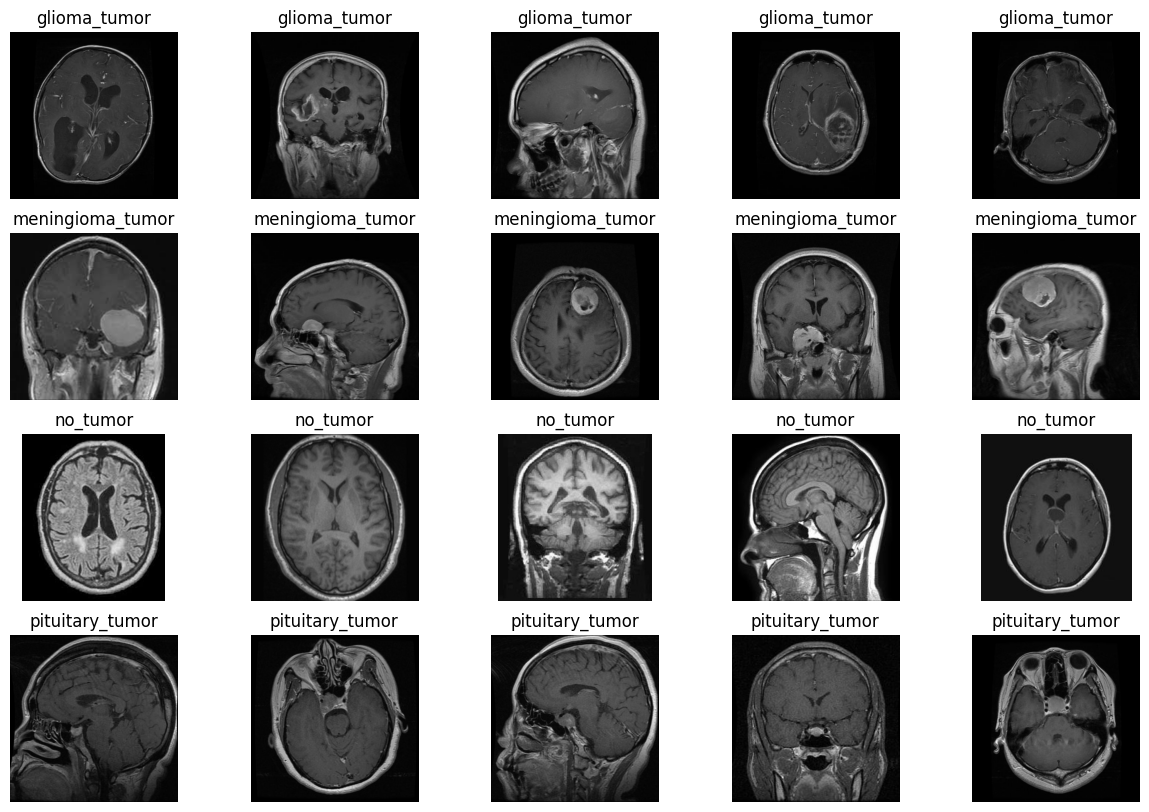

Epoch 1/5
58/58 [==============================] - 491s 8s/step - loss: 0.9219 - accuracy: 0.6851 - val_loss: 1.1180 - val_accuracy: 0.3994
Epoch 2/5
58/58 [==============================] - 485s 8s/step - loss: 0.4277 - accuracy: 0.8562 - val_loss: 0.6678 - val_accuracy: 0.8019
Epoch 3/5
58/58 [==============================] - 476s 8s/step - loss: 0.3120 - accuracy: 0.9103 - val_loss: 0.6467 - val_accuracy: 0.7461
Epoch 4/5
58/58 [==============================] - 476s 8s/step - loss: 0.2023 - accuracy: 0.9382 - val_loss: 1.0126 - val_accuracy: 0.5263
Epoch 5/5
58/58 [==============================] - 482s 8s/step - loss: 0.1755 - accuracy: 0.9470 - val_loss: 0.4196 - val_accuracy: 0.8762


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception

glioma_tumor = '/content/Training/glioma_tumor'
meningioma_tumor = '/content/Training/meningioma_tumor'
no_tumor = '/content/Training/no_tumor'
pituitary_tumor = '/content/Training/pituitary_tumor'

class_directories = [glioma_tumor, meningioma_tumor, no_tumor, pituitary_tumor]
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

file_paths = []
labels = []

for i, directory in enumerate(class_directories):
    file_list = os.listdir(directory)
    for file_name in file_list:
        file_path = os.path.join(directory, file_name)
        file_paths.append(file_path)
        labels.append(class_labels[i])

file_paths_series = pd.Series(file_paths, name="filepaths")
labels_series = pd.Series(labels, name="labels")
df = pd.DataFrame({'filepaths': file_paths_series, 'labels': labels_series})

train_df, test_df = train_test_split(df, test_size=0.25, random_state=42, stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df.labels)

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue = hsv_image[:, :, 0]
    saturation = hsv_image[:, :, 1]
    value = hsv_image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    hsv_image[:, :, 2] = value
    image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

    return image

image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image)
)

target_size = (128, 128)
batch_size = 32

train = image_gen.flow_from_dataframe(dataframe=train_df, x_col="filepaths", y_col="labels",
                                      target_size=target_size,
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=batch_size,
                                      shuffle=True)

test = image_gen.flow_from_dataframe(dataframe=test_df, x_col="filepaths", y_col="labels",
                                     target_size=target_size,
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=batch_size,
                                     shuffle=False)

val = image_gen.flow_from_dataframe(dataframe=val_df, x_col="filepaths", y_col="labels",
                                    target_size=target_size,
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=batch_size,
                                    shuffle=False)

num_images_per_class = 5
class_labels = list(train.class_indices.keys())

plt.figure(figsize=(15, 10))
for label in class_labels:
    indices = train_df[train_df['labels'] == label].index
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, class_labels.index(label)*num_images_per_class + i + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))
        plt.title(label)
        plt.axis('off')
plt.show()

base_model = Xception(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train, epochs=5, validation_data=val)

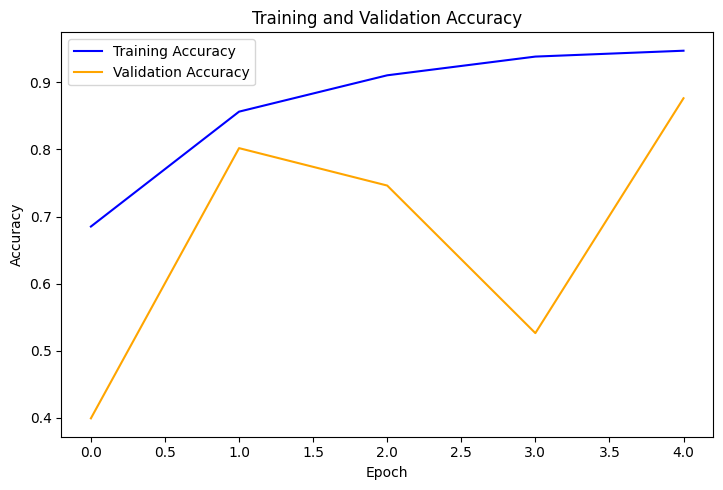

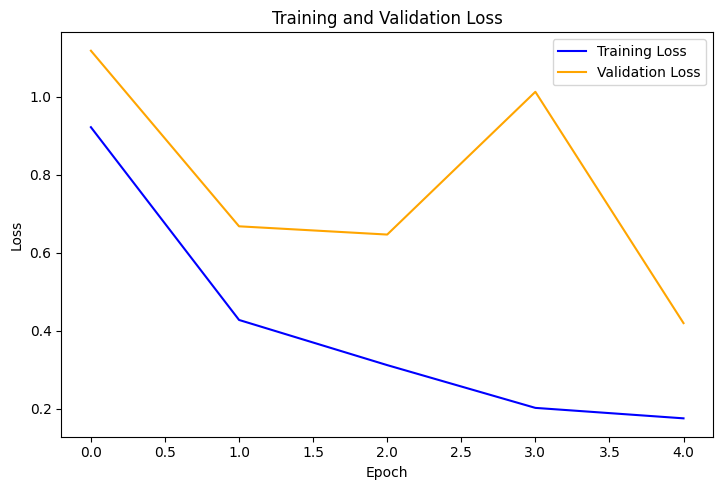

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


23/23 [==============================] - 45s 2s/step


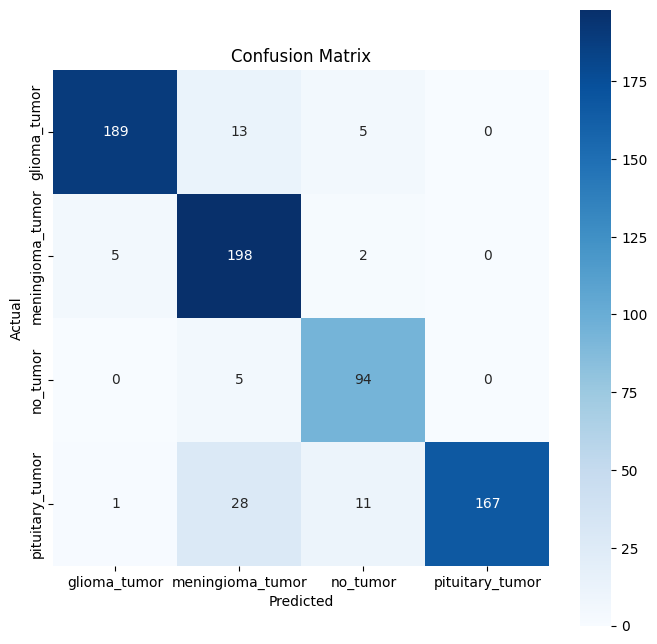

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = test.classes

conf_matrix = confusion_matrix(true_classes, y_pred_classes)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

*italicized text*

## CNN

In [ ]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [ ]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


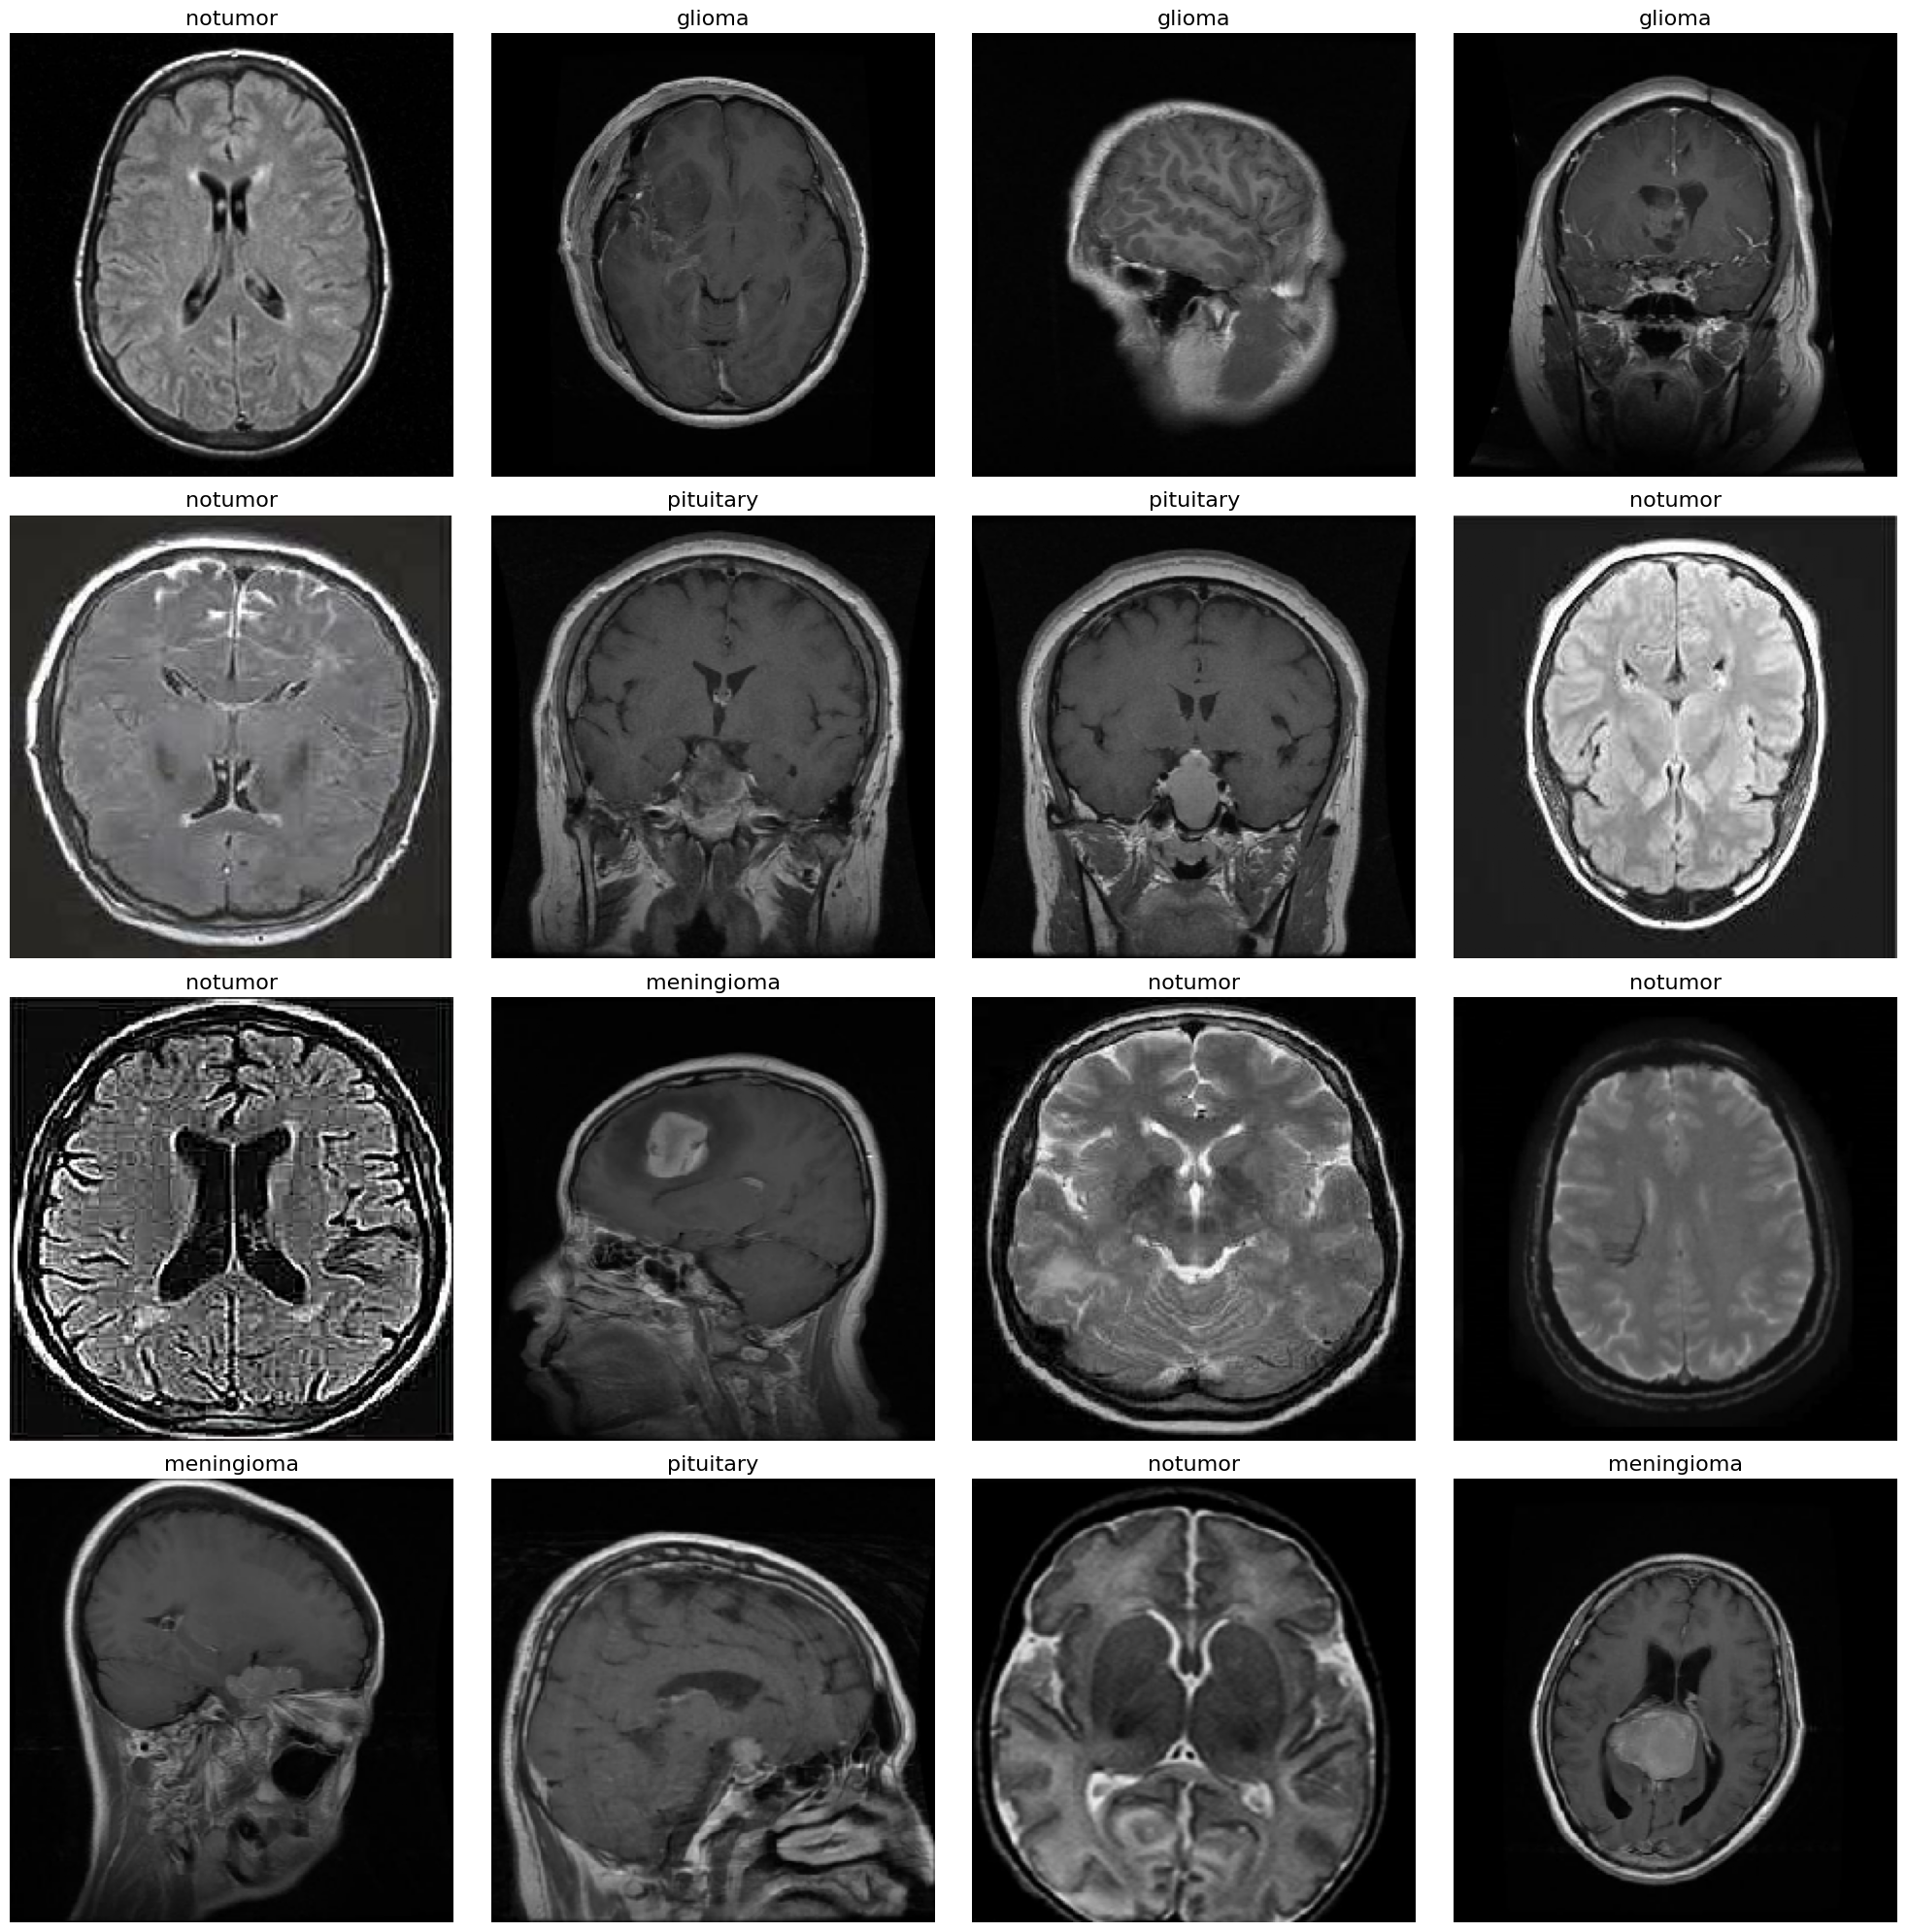

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(class_count, activation = "softmax"))

In [ ]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


model.summary()

In [ ]:
epochs = 10

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
model.save('Brain Tumor.h5')